<center>
<h4>Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación</h4>
<h3>Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones</h3>
</center>

<h1>Práctico 2 Aprendizaje Profundo</h1>

**Integrantes:** Sofía Luján y Nair Trógolo.

El objetivo de este trabajo es predecir la velocidad de adopción de un conjunto de mascotas utilizando distintos modelos de aprendizaje profundo sobre el conjunto de datos de petfinder. 





### Instalación de tensorflow

In [2]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

from tensorflow.keras import layers, models

TensorFlow 2.x selected.


In [3]:
!pip install mlflow

     |████████████████████████████████| 14.6MB 2.7MB/s 
     |████████████████████████████████| 1.1MB 41.5MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
     |████████████████████████████████| 460kB 60.7MB/s 
     |████████████████████████████████| 92kB 14.6MB/s 
     |████████████████████████████████| 143kB 70.1MB/s 
     |████████████████████████████████| 471kB 55.4MB/s 
     |████████████████████████████████| 71kB 12.4MB/s 
     |████████████████████████████████| 204kB 77.0MB/s 
  Created wheel for mlflow: filename=mlflow-1.4.0-cp36-none-any.whl size=14750368 sha256=578af202299477cd0067d74b20efa6d1df3d4e85f7c844a82aba57f4eab5746a
  Stored in directory: /root/.cache/pip/wheels/5d/0e/cc/79315d41833b92a8a9e276716874f2c1dc654018b44632dc06
  Created wheel for alembic: filename=alembic-1.3.1-py2.py3-none-any.whl size=144523 sha256=c3028b79f8e241afa6fd7c91bc794e74e4a9ba7e8242b58c5d274a1b021f179a
  Stored in directory: /root/.cache/pip/wheels/b2/d4/19/5ab879d30af7cbc79e6dcc1d42

In [4]:
import tensorflow as tf
print(tf.__version__)

2.0.0


### Visualización de la distribución del target

In [0]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [199]:
train = pd.read_csv('https://raw.githubusercontent.com/solujan/AprendizajeProfundo/master/data/train.csv')
train.head()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,Description,AdoptionSpeed,PID
0,2,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,Nibble is a 3+ month old ball of cuteness. He ...,2,0
1,1,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,"Good guard dog, very alert, active, obedience ...",2,3
2,1,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,This handsome yet cute boy is up for adoption....,2,4
3,2,3,266,0,2,5,6,0,2,1,2,2,2,1,1,0,41326,This is a stray kitten that came to my house. ...,2,5
4,2,12,264,264,1,1,0,0,2,3,2,2,3,1,1,300,41326,anyone within the area of ipoh or taiping who ...,1,6


In [210]:
train.describe()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,AdoptionSpeed,PID
count,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000,10582.000000
mean,1.454734,10.520412,265.469854,74.388868,1.779059,2.230675,3.236912,1.856738,1.860518,1.460971,1.729730,1.566528,1.912115,1.036666,1.584011,20.809960,41345.994613,2.518900,7477.025799
std,0.497970,18.374027,60.121490,123.434010,0.684763,1.743985,2.748595,2.974465,0.547535,0.593843,0.670791,0.701482,0.564041,0.198228,1.488348,78.397243,32.409109,1.176018,4310.921553
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,41324.000000,0.000000,0.000000
25%,1.000000,2.000000,265.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,2.000000,3768.250000
50%,1.000000,3.000000,266.000000,0.000000,2.000000,2.000000,2.000000,0.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,2.000000,7473.500000
75%,2.000000,12.000000,307.000000,188.000000,2.000000,3.000000,6.000000,5.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,0.000000,41401.000000,4.000000,11200.750000
max,2.000000,255.000000,307.000000,307.000000,3.000000,7.000000,7.000000,7.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,20.000000,3000.000000,41415.000000,4.000000,14992.000000


In [0]:
Fee_max = train.Fee.std() * 3 + train.Fee.mean()
ds = train[(train.Fee < Fee_max) | (train.Fee.isnull())]


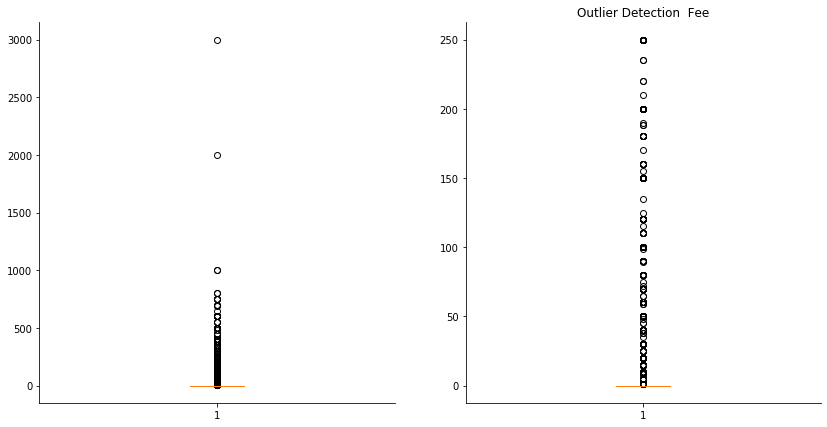

In [201]:
plt.figure(figsize=(14,7))
plt.subplot(1, 2, 1)
plt.boxplot(train.Fee)

plt.subplot(1, 2, 2)
plt.boxplot(ds.Fee)

plt.title('Outlier Detection  Fee')
sns.despine()

In [0]:
age_max = ds.Age.std() * 3 + ds.Age.mean()
ds = ds[(ds.Age < age_max) | (ds.Age.isnull())]

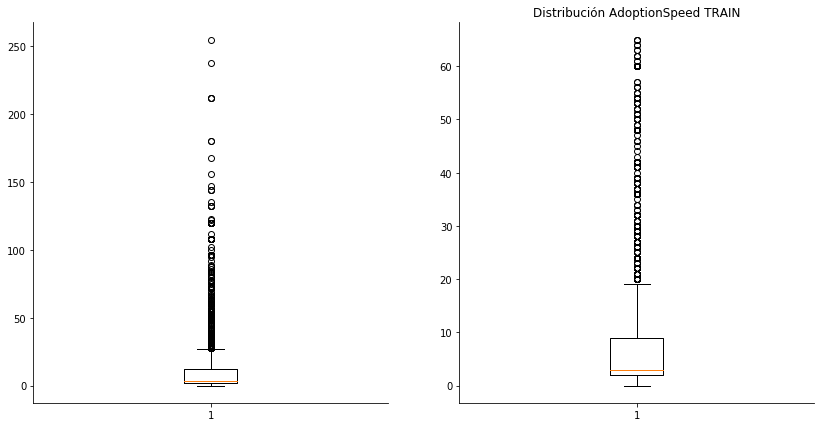

In [203]:
plt.figure(figsize=(14,7))
plt.subplot(1, 2, 1)
plt.boxplot(train.Age)

plt.subplot(1, 2, 2)
plt.boxplot(ds.Age)

plt.title('Distribución AdoptionSpeed TRAIN')
sns.despine()

En el gráfico anterior observamos que todas las clases presentan una distribución similar salvo la clase 0, con lo cual nos encontramos frente a un claro problema de desbalanceo de clases con una clase minoritaria. Esto podría influir en el análisis de los resultados.

### Instalación de mlflow

In [12]:
!pip install mlflow

In [0]:

def clean_dataset(train):
    Fee_max = train.Fee.std() * 3 + train.Fee.mean()
    ds = train[(train.Fee < Fee_max) | (train.Fee.isnull())] 
    age_max = ds.Age.std() * 3 + ds.Age.mean()
    return ds[(ds.Age < age_max) | (ds.Age.isnull())] 


def read_args():
    parser = argparse.ArgumentParser(
        description='Training a MLP on the petfinder dataset')
    # Here you have some examples of classifier parameters. You can add
    # more arguments or change these if you need to.
    parser.add_argument('--dataset_dir', default='../petfinder_dataset', type=str,
                        help='Directory with the training and test files.')
    parser.add_argument('--hidden_layer_sizes', nargs='+', default=[100], type=int,
                        help='Number of hidden units of each hidden layer.')
    parser.add_argument('--epochs', default=10, type=int,
                        help='Number of epochs to train.')
    parser.add_argument('--dropout', nargs='+', default=[0.5], type=float,
                        help='Dropout ratio for every layer.')
    parser.add_argument('--batch_size', type=int, default=32,
                        help='Number of instances in each batch.')
    parser.add_argument('--experiment_name', type=str, default='Base model',
                        help='Name of the experiment, used in mlflow.')
    args = parser.parse_args()

    assert len(args.hidden_layer_sizes) == len(args.dropout)
    return args


def process_features(df, one_hot_columns, numeric_columns, embedded_columns, test=False):
    direct_features = []

    # Create one hot encodings
    for one_hot_col, max_value in one_hot_columns.items():
        direct_features.append(tf.keras.utils.to_categorical(df[one_hot_col] - 1, max_value))

    # TODO Create and append numeric columns
    # Don't forget to normalize!
    # ....
    
    scaler = MinMaxScaler()
    direct_features.append(scaler.fit_transform(df[numeric_columns]))
    
    
    # Concatenate all features that don't need further embedding into a single matrix.
    features = {'direct_features': np.hstack(direct_features)}

    # Create embedding columns - nothing to do here. We will use the zero embedding for OOV
    for embedded_col in embedded_columns.keys():
       features[embedded_col] = df[embedded_col].values

    if not test:
        nlabels = df[TARGET_COL].unique().shape[0]
        # Convert labels to one-hot encodings
        targets = tf.keras.utils.to_categorical(df[TARGET_COL], nlabels)
    else:
        targets = None
    
    return features, targets



def load_dataset(dataset_dir, batch_size):

    # Read train dataset (and maybe dev, if you need to...)
    dataset, dev_dataset = train_test_split(
        pd.read_csv('https://raw.githubusercontent.com/solujan/AprendizajeProfundo/master/data/train.csv'), 
        test_size=0.2)
    
    state_labels = pd.read_csv('https://raw.githubusercontent.com/solujan/AprendizajeProfundo/master/data/state_labels.csv')
    state_labels = state_labels.reset_index()
    dataset = dataset.apply(lambda x: x.replace(state_labels['StateID'].to_list(), state_labels['index'].to_list()))
    dev_dataset = dev_dataset.apply(lambda x: x.replace(state_labels['StateID'].to_list(), state_labels['index'].to_list()))
  
    test_dataset = pd.read_csv('https://raw.githubusercontent.com/solujan/AprendizajeProfundo/master/data/test.csv')
    test_dataset = test_dataset.apply(lambda x: x.replace(state_labels['StateID'].to_list(), state_labels['index'].to_list()))
    print('Training samples {}, test_samples {}'.format(
        dataset.shape[0], test_dataset.shape[0]))
    
    return dataset, dev_dataset, test_dataset

def build_model(args, nlabels, direct_features_input_shape, embedded_columns):
    embedding_layers = []
    inputs = []
    for embedded_col, max_value in embedded_columns.items():
        input_layer = layers.Input(shape=(1,), name=embedded_col)
        inputs.append(input_layer)
        # Define the embedding layer
        embedding_size = int(max_value / 4)
        embedding_layers.append(
            tf.squeeze(layers.Embedding(input_dim=max_value, output_dim=embedding_size)(input_layer), axis=-2))
        print('Adding embedding of size {} for layer {}'.format(embedding_size, embedded_col))

    # Add the direct features already calculated
    direct_features_input = layers.Input(shape=direct_features_input_shape, name='direct_features')
    inputs.append(direct_features_input)
        
    # Concatenate everything together
    #features = layers.concatenate(embedding_layers + [direct_features_input])
    features = direct_features_input
    dense1 = layers.Dense(100, activation='relu')(features)
    batchNor1 = layers.BatchNormalization(momentum=0)(dense1)
    dropout1 = layers.Dropout(0.3)(batchNor1)
    dense2 = layers.Dense(50, activation='relu')(dropout1)
    batchNor2 = layers.BatchNormalization(momentum=0)(dense2)
    dropout2 = layers.Dropout(0.5)(batchNor2)
    output_layer = layers.Dense(nlabels, activation='softmax')(dropout2)

    model = models.Model(inputs=inputs, outputs=output_layer)

    return model


def main():
    tf.keras.backend.clear_session()
    #args = read_args()
    args = {
      'hidden_layer_sizes' : [100,50],
      'dropout': [0.3, 0.5],
      'dataset_dir' : '',
      'batch_size' : 32,
      'epochs' : 20,
      'optimizer': tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True), 
      'loss': 'categorical_crossentropy'
    }
    print(args)
    
    dataset, dev_dataset, test_dataset = load_dataset(args['dataset_dir'], args['batch_size'])
    nlabels = dataset[TARGET_COL].unique().shape[0]
    
    # It's important to always use the same one-hot length
    one_hot_columns = {
        one_hot_col: dataset[one_hot_col].max()
        for one_hot_col in ['Gender', 'Color1','Color2', 'Color3', 'Type']
    }
    embedded_columns = {
        embedded_col: dataset[embedded_col].max() + 1
        for embedded_col in ['Breed1','Breed2','State']
    }
    numeric_columns = ['Age', 'Fee']
    
    # TODO (optional) put these three types of columns in the same dictionary with "column types"
    X_train, y_train = process_features(dataset, one_hot_columns, numeric_columns, embedded_columns)
    direct_features_input_shape = (X_train['direct_features'].shape[1],)
    X_dev, y_dev = process_features(dev_dataset, one_hot_columns, numeric_columns, embedded_columns)
    X_test, y_test = process_features(test_dataset, one_hot_columns, numeric_columns, embedded_columns, test=True)
    
    # Create the tensorflow Dataset
    
    # TODO shuffle the train dataset!
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(5).batch(args['batch_size'])
    dev_ds = tf.data.Dataset.from_tensor_slices((X_dev, y_dev)).shuffle(5).batch(args['batch_size'])
    test_ds = tf.data.Dataset.from_tensor_slices(X_test).shuffle(5).batch(args['batch_size'])
    
    # TODO: Build the Keras model
    
    model = build_model(args, nlabels, direct_features_input_shape, embedded_columns)   

    print(model.summary())
    #SVG(model_to_dot(model, dpi=72).create(prog='dot', format='svg'))
    
    model.compile(loss=args['loss'],
                   optimizer=args['optimizer'],
                  metrics=['accuracy']) 
    
    
    # Prediction
    
    #predictions = model.predict(test_ds)
    #print(predictions)
    experiment_name = "COLAB"
    mlflow.set_experiment(experiment_name)
    
    with mlflow.start_run(nested=True):
        # Log model hiperparameters first
        mlflow.set_tag('ejercicio', '1') 
        mlflow.log_param('hidden_layer_size', args['hidden_layer_sizes'])
        mlflow.log_param('embedded_columns', embedded_columns)
        mlflow.log_param('one_hot_columns', one_hot_columns)
        mlflow.log_param('numerical_columns', numeric_columns)  # Not using these yet
        mlflow.log_param('epochs', args['epochs'])
        mlflow.log_param('batch_size', args['batch_size'])
        mlflow.log_param('dropout', args['dropout'])
        mlflow.log_param('loss', args['loss'])
        mlflow.log_param('optimizer', args['optimizer'].get_config())
        
        from keras.callbacks import EarlyStopping

        callbacks = [
            EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=2, 
                          verbose=1, 
                          mode='auto', 
                          baseline=None, 
                          restore_best_weights=False)
        ]
        
        # Train
        history = model.fit(train_ds, 
                            epochs=args['epochs'], 
                            validation_data=dev_ds,
                            callbacks= callbacks,
                            verbose=1);

        # TODO: analyze history to see if model converges/overfits
        print(history)
        # TODO: Evaluate the model, calculating the metrics.
        # Option 1: Use the model.evaluate() method. For this, the model must be
        # already compiled with the metrics.
        # performance = model.evaluate(X_test, y_test)

        loss, accuracy = 0, 0
        loss, accuracy = model.evaluate(dev_ds)
        print("*** Dev loss: {} - accuracy: {}".format(loss, accuracy))
        mlflow.log_metric('dev-loss', loss)
        mlflow.log_metric('dev-accuracy', accuracy)

        loss, accuracy = model.evaluate(train_ds)
        print("*** Train loss: {} - accuracy: {}".format(loss, accuracy))
        mlflow.log_metric('train-loss', loss)
        mlflow.log_metric('train-accuracy', accuracy)
        
        # Option 2: Use the model.predict() method and calculate the metrics using
        # sklearn. We recommend this, because you can store the predictions if
        # you need more analysis later. Also, if you calculate the metrics on a
        # notebook, then you can compare multiple classifiers.
        
        #predictions = 'No prediction yet'
        predictions = model.predict(test_ds)
        #Convert preditcion to classes
        pred = []
        for i in range(len(predictions)):
	        pred.append(np.argmax(predictions[i]))
         
        mlflow.log_param("prediction", pred)
        # Create submission file
        submission = pd.DataFrame(list(zip(test_dataset.PID, pred)), columns=["PID", "AdoptionSpeed"])
        submission.to_csv("submission.csv", header=True, index=False)
        
        save_history('1', history)
        
        #grafico
        plt.figure(figsize=(15,12))
        
        plt.subplot(2,1,1)
        plt.plot(history.history['loss'], label='Loss train')
        plt.plot(history.history['val_loss'], color='red', label='Loss validation')
        plt.title('model loss')
        plt.ylabel('loss', size='18')
        plt.xlabel('epoch', size='18')
        plt.legend()
                
        plt.subplot(2,1,2)
        plt.plot(history.history['acc'], label='Accuracy train')
        plt.plot(history.history['val_acc'], color='red', label='Accuracy validation')
        plt.title('model accuracy')
        plt.ylabel('accuracy', size='18')
        plt.xlabel('epoch',size='18')
        plt.legend()
        plt.show()
        
    print('All operations completed')

{'hidden_layer_sizes': [100, 50], 'dropout': [0.3, 0.5], 'dataset_dir': '', 'batch_size': 32, 'epochs': 20, 'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f8a3203c7f0>, 'loss': 'categorical_crossentropy'}
Training samples 8465, test_samples 4411
Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
direct_features (InputLayer)    [(None, 28)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 100)          2900        direct_features[0][0]            
____________________________________________________________________________________

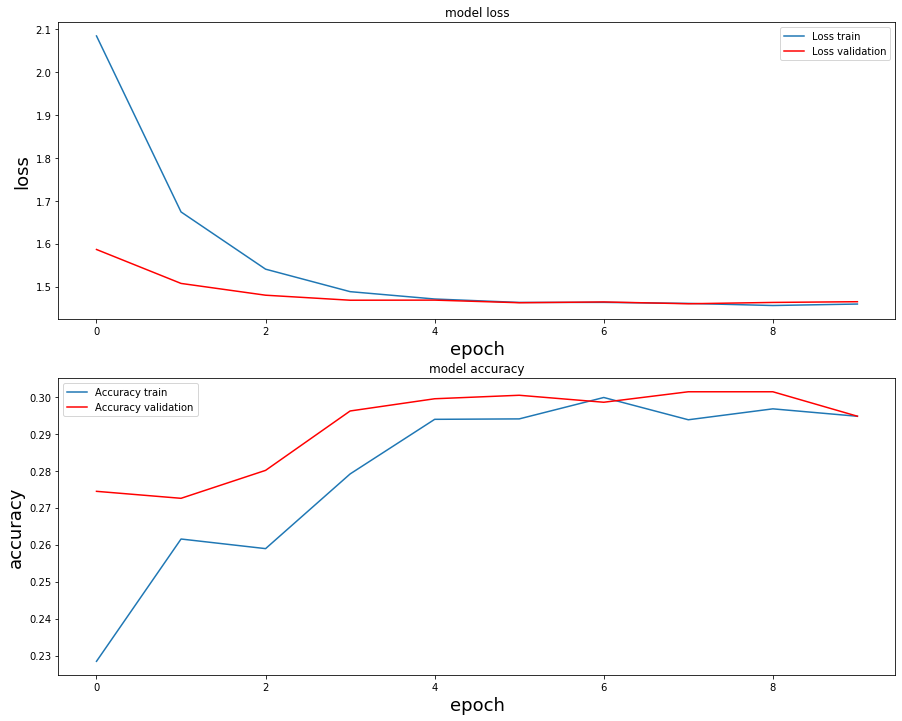

All operations completed


In [0]:
main()

# Ejercicio 2

In [14]:
! curl -L -o glove.6B.zip https://cs.famaf.unc.edu.ar/~ccardellino/resources/diplodatos/glove.6B.zip
!unzip glove.6B.zip glove.6B.100d.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  822M  100  822M    0     0  8846k      0  0:01:35  0:01:35 --:--:-- 8312k
Archive:  glove.6B.zip
  inflating: glove.6B.100d.txt       


In [0]:
def clean_dataset(train):
    Fee_max = train.Fee.std() * 3 + train.Fee.mean()
    ds = train[(train.Fee < Fee_max) | (train.Fee.isnull())] 
    age_max = ds.Age.std() * 3 + ds.Age.mean()
    return ds[(ds.Age < age_max) | (ds.Age.isnull())] 

In [0]:
def process_feature(df):
    df['SQAge'] = df['Age']  ** 2
    df['SQQuantity'] = df['Quantity']  ** 2
    return df

In [350]:
def load_dataset():

    # Read train dataset (and maybe dev, if you need to...)
    dataset = pd.read_csv('https://raw.githubusercontent.com/solujan/AprendizajeProfundo/master/data/train.csv')
    
    state_labels = pd.read_csv('https://raw.githubusercontent.com/solujan/AprendizajeProfundo/master/data/state_labels.csv')
    state_labels = state_labels.reset_index()
    dataset = dataset.apply(lambda x: x.replace(state_labels['StateID'].to_list(), state_labels['index'].to_list()))
    
  
    test_dataset = pd.read_csv('https://raw.githubusercontent.com/solujan/AprendizajeProfundo/master/data/test.csv')
    test_dataset = test_dataset.apply(lambda x: x.replace(state_labels['StateID'].to_list(), state_labels['index'].to_list()))
    print('Training samples {}, test_samples {}'.format(
        dataset.shape[0], test_dataset.shape[0]))
    
    return dataset, test_dataset

dataset, test_dataset = load_dataset()
target_col = 'AdoptionSpeed'
nlabels = dataset[target_col].unique().shape[0]

dataset = clean_dataset(dataset)
dataset = process_feature(dataset)

Training samples 10582, test_samples 4411


### Tokenizacion

In [0]:
SW = set(stopwords.words("english"))

def tokenize_description(description):
    return [w.lower() for w in word_tokenize(description, language="english") if w.lower() not in SW]

# Fill the null values with the empty string to avoid errors with NLTK tokenization
dataset["TokenizedDescription"] = dataset["Description"].fillna(value="").apply(tokenize_description)

### Tamaño de las descripciones

In [352]:
pprint(dataset["TokenizedDescription"].apply(len).describe())

count    10107.000000
mean        43.814287
std         47.528466
min          0.000000
25%         16.000000
50%         31.000000
75%         55.000000
max        803.000000
Name: TokenizedDescription, dtype: float64


El 75% de las secuencias tienen 55 palabras o menos. Esto es un buen punto de partida, así que podemos establecer el tamaño máximo de las secuencia en 55 palabras.

In [0]:
MAX_SEQUENCE_LEN = 55

### Vocabulario

In [0]:
vocabulary = corpora.Dictionary(dataset["TokenizedDescription"])
vocabulary.filter_extremes(no_below=1, no_above=1.0, keep_n=10000)

### Word Embeddings (GloVe)

In [355]:
embeddings_index = {}

with open("glove.6B.100d.txt", "r") as fh:
    for line in fh:
        values = line.split()
        word = values[0]
        if word in vocabulary.token2id:  # Only use the embeddings of words in our vocabulary
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

print("Found {} word vectors.".format(len(embeddings_index)))

Found 7817 word vectors.


## Creación de los datasets

Datos que son "one-hot-encoded", "embeddings" y numéricos.

In [0]:
one_hot_columns = {
        one_hot_col: dataset[one_hot_col].max()
        for one_hot_col in ['Gender', 'Color1','Color2', 'Color3', 'Type', 'FurLength','Type']
    }
embedded_columns = {
    embedded_col: dataset[embedded_col].max() + 1
    for embedded_col in ['Breed1','Breed2','State']
}
numeric_columns = ['Age', 'Fee', 'Quantity','SQQuantity','SQAge']
for num_column in numeric_columns:
  dataset[num_column] = StandardScaler().fit_transform(dataset[[num_column]].values)



### Generador del conjunto de datos¶


In [357]:
def dataset_generator(ds, test_data=False):
    for _, row in ds.iterrows():
        instance = {}

        direct_features = []

        # Create one hot encodings
        for one_hot_col, max_value in one_hot_columns.items():
            direct_features.append( tf.keras.utils.to_categorical(row[one_hot_col] - 1, max_value))

        # TODO Create and append numeric columns
        # Don't forget to normalize!
      
        direct_features.append(row[numeric_columns])
        
        
        # One hot encoded features
        instance["direct_features"] =  np.hstack(direct_features)
        
        
        # Embedded features
        for embedded_col in embedded_columns:
            instance[embedded_col] = [row[embedded_col]]
        
        # Document to indices for text data, truncated at MAX_SEQUENCE_LEN words
        instance["description"] = vocabulary.doc2idx(
            row["TokenizedDescription"],
            unknown_word_index=len(vocabulary)
        )[:MAX_SEQUENCE_LEN]
        
        # One hot encoded target for categorical crossentropy
        if not test_data:
            target = tf.keras.utils.to_categorical(row[target_col], nlabels)
            yield instance, target
        else:
            yield instance

# Set output types of the generator (for numeric types check the type is valid)
instance_types = {
    "direct_features": tf.float32,
    "description": tf.int32
}

for embedded_col in embedded_columns:
    instance_types[embedded_col] = tf.int32
        
tf_dataset = tf.data.Dataset.from_generator(
    lambda: dataset_generator(dataset),
    output_types=(instance_types, tf.int32)
)
for data, target in tf_dataset.take(2):
    pprint(data)
    pprint(target)
    print()


{'Breed1': <tf.Tensor: id=571931, shape=(1,), dtype=int32, numpy=array([299], dtype=int32)>,
 'Breed2': <tf.Tensor: id=571932, shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>,
 'State': <tf.Tensor: id=571933, shape=(1,), dtype=int32, numpy=array([13], dtype=int32)>,
 'description': <tf.Tensor: id=571934, shape=(42,), dtype=int32, numpy=
array([23,  2, 20, 24,  4, 10,  1, 11, 26,  1, 27,  9,  6, 21,  3,  8, 15,
       22, 33,  7, 13, 30,  1, 29, 18, 17,  1, 12, 31, 14,  5,  6, 16,  1,
       19, 28, 25, 32, 23,  0,  5,  1], dtype=int32)>,
 'direct_features': <tf.Tensor: id=571935, shape=(34,), dtype=float32, numpy=
array([ 1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        1.

## Datos de entrenamiento y validación¶


In [0]:
TRAIN_SIZE = int(dataset.shape[0] * 0.8)
DEV_SIZE = dataset.shape[0] - TRAIN_SIZE
BATCH_SIZE = 64

shuffled_dataset = tf_dataset.shuffle(TRAIN_SIZE + DEV_SIZE, seed=42)

# Pad the datasets to the max value for all the "non sequence" features
padding_shapes = (
    {k: [-1] for k in ["direct_features"] + list(embedded_columns.keys())},
    [-1]
)

# Pad to MAX_SEQUENCE_LEN for sequence features
padding_shapes[0]["description"] = [MAX_SEQUENCE_LEN]

# Pad values are irrelevant for non padded data
padding_values = (
    {k: 0 for k in list(embedded_columns.keys())},
    0
)

# Padding value for direct features should be a float
padding_values[0]["direct_features"] = np.float32(0)

# Padding value for sequential features is the vocabulary length + 1
padding_values[0]["description"] = len(vocabulary) + 1

train_dataset = shuffled_dataset.skip(DEV_SIZE)\
    .padded_batch(BATCH_SIZE, padded_shapes=padding_shapes, padding_values=padding_values)

dev_dataset = shuffled_dataset.take(DEV_SIZE)\
    .padded_batch(BATCH_SIZE, padded_shapes=padding_shapes, padding_values=padding_values)

## Construyendo el modelo

### Matriz de embeddings de palabras¶

In [0]:
EMBEDDINGS_DIM = 100  # Given by the model (in this case glove.6B.100d)

embedding_matrix = np.zeros((len(vocabulary) + 2, 100))

for widx, word in vocabulary.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[widx] = embedding_vector
    else:
        # Random normal initialization for words without embeddings
        embedding_matrix[widx] = np.random.normal(size=(100,))  

# Random normal initialization for unknown words
embedding_matrix[len(vocabulary)] = np.random.normal(size=(100,))

### Definiendo los inputs del modelo¶


In [360]:
tf.keras.backend.clear_session()

# Add one input and one embedding for each embedded column
embedding_layers = []
inputs = []
for embedded_col, max_value in embedded_columns.items():
    input_layer = tf.keras.layers.Input(shape=(1,), name=embedded_col)
    inputs.append(input_layer)
    # Define the embedding layer
    embedding_size = int(max_value / 4)
    embedding_layers.append(
        tf.squeeze(
            tf.keras.layers.Embedding(
                input_dim=max_value, 
                output_dim=embedding_size
            )(input_layer), 
            axis=-2
        )
    )
    print('Adding embedding of size {} for layer {}'.format(embedding_size, embedded_col))

# Add the direct features already calculated
direct_features_input = tf.keras.layers.Input(
    shape=(sum(one_hot_columns.values())+len(numeric_columns),), 
    name='direct_features'
)
inputs.append(direct_features_input)
print(direct_features_input.shape)

# Word embedding layer
description_input = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LEN,), name="description")
inputs.append(description_input)

word_embeddings_layer = tf.keras.layers.Embedding(
    embedding_matrix.shape[0],
    EMBEDDINGS_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LEN,
    trainable=False,
    name="word_embedding"
)(description_input)

Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 3 for layer State
(None, 34)


### CNN: la red que trabajará con el texto¶


In [0]:
DESCRIPTION_FEATURES_LAYER_SIZE = 512
FILTER_WIDTHS = [2, 3, 5]  # Take 2, 3, and 5 words
FILTER_COUNT = 64
 
conv_layers = []
for filter_width in FILTER_WIDTHS:
    layer = tf.keras.layers.Conv1D(
        FILTER_COUNT,
        filter_width,
        activation="relu",
        name="conv_{}_words".format(filter_width)
    )(word_embeddings_layer)
    layer = tf.keras.layers.GlobalMaxPooling1D(name="max_pool_{}_words".format(filter_width))(layer)
    conv_layers.append(layer)
 
description_features = tf.keras.layers.Concatenate(name="convolved_features")(conv_layers)
    


### Definiendo el feature map final de la red y el resto de la red


In [0]:
HIDDEN_LAYER_SIZE = 128

feature_map = tf.keras.layers.Concatenate(name="feature_map")(
    embedding_layers + [description_features, direct_features_input]
)

dense1 = tf.keras.layers.Dense(512, activation='relu')(feature_map)
batchNor1 = tf.keras.layers.BatchNormalization(momentum=0)(dense1)
dropout1 = tf.keras.layers.Dropout(0.3)(batchNor1)
dense2 = tf.keras.layers.Dense(128, activation='relu')(dropout1)
batchNor2 = tf.keras.layers.BatchNormalization(momentum=0)(dense2)
dropout2 = tf.keras.layers.Dropout(0.3)(batchNor2)
output_layer = tf.keras.layers.Dense(nlabels, activation='softmax', name="output")(dropout2)


model = tf.keras.models.Model(inputs=inputs, outputs=[output_layer], name="amazing_model")

### Compilar el modelo

In [363]:
model.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True),
              metrics=['accuracy'])
model.summary()

Model: "amazing_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
description (InputLayer)        [(None, 55)]         0                                            
__________________________________________________________________________________________________
word_embedding (Embedding)      (None, 55, 100)      1000200     description[0][0]                
__________________________________________________________________________________________________
Breed1 (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
Breed2 (InputLayer)             [(None, 1)]          0                                            
______________________________________________________________________________________

### Graph de la red

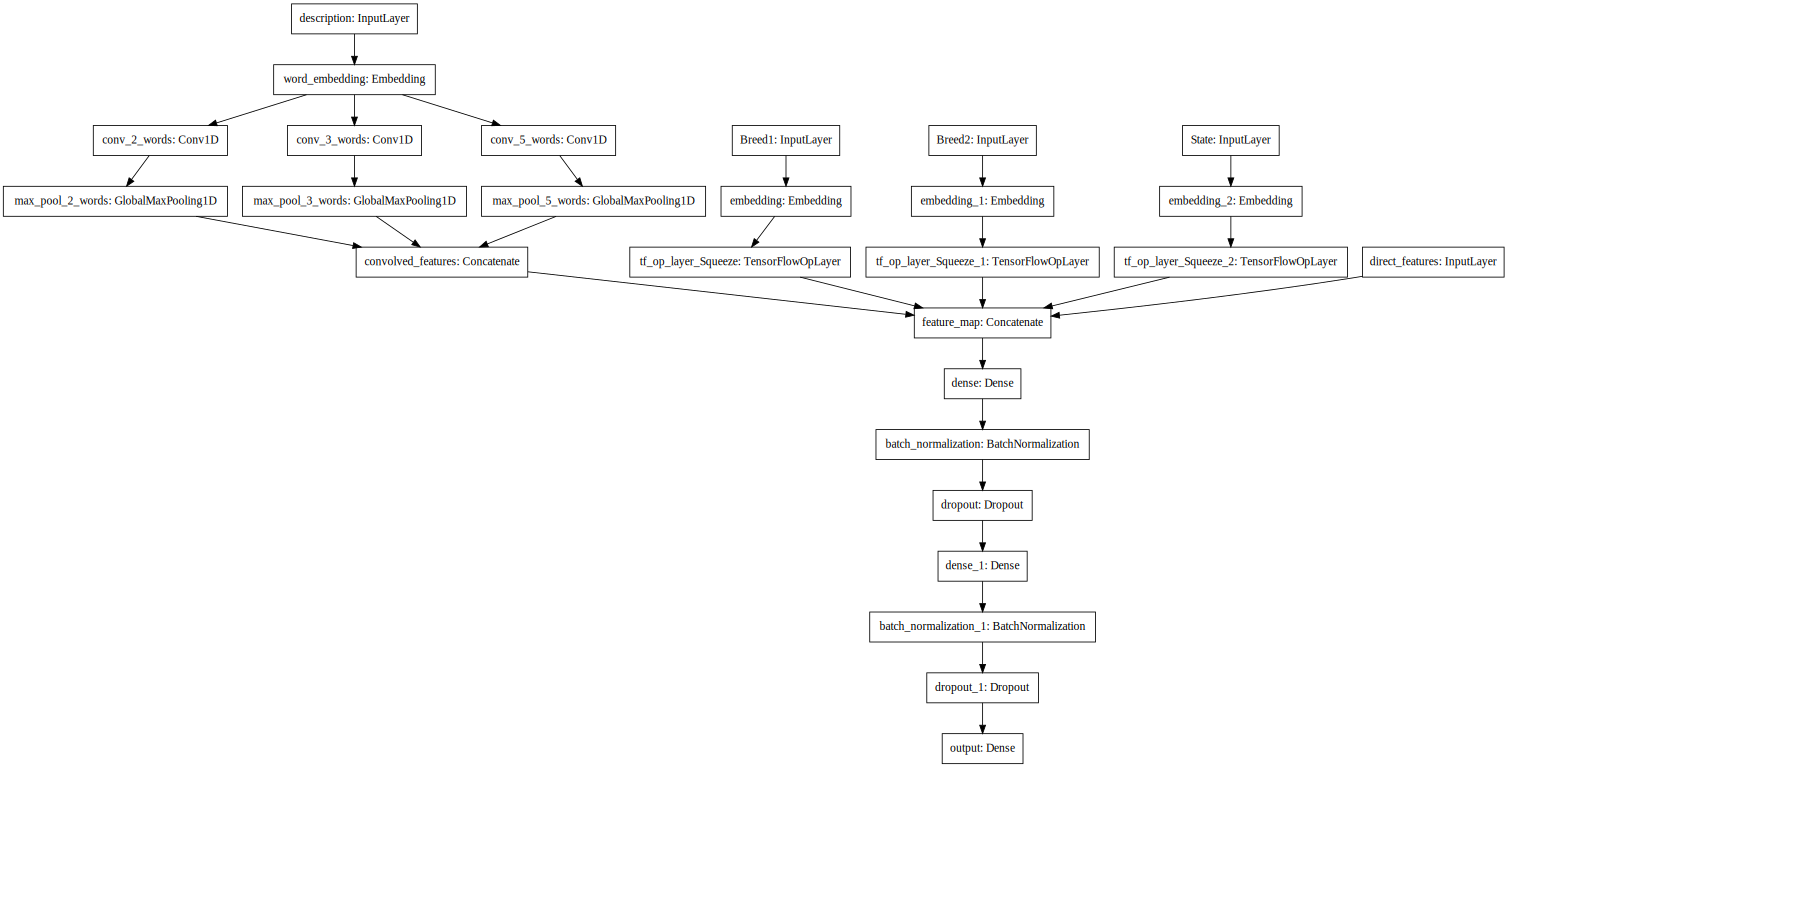

In [364]:
SVG(tf.keras.utils.model_to_dot(model, dpi=60).create(prog='dot', format='svg'))


## Trainning model

Epoch 1/20
127/127 [==============================] - 28s 220ms/step - loss: 1.8769 - accuracy: 0.2591 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
127/127 [==============================] - 26s 206ms/step - loss: 1.5540 - accuracy: 0.3472 - val_loss: 1.3345 - val_accuracy: 0.4100
Epoch 3/20
127/127 [==============================] - 26s 205ms/step - loss: 1.4255 - accuracy: 0.3881 - val_loss: 1.3009 - val_accuracy: 0.4674
Epoch 4/20
127/127 [==============================] - 26s 205ms/step - loss: 1.3357 - accuracy: 0.4386 - val_loss: 1.1747 - val_accuracy: 0.5297
Epoch 5/20
127/127 [==============================] - 26s 207ms/step - loss: 1.2547 - accuracy: 0.4779 - val_loss: 1.0485 - val_accuracy: 0.6009
Epoch 6/20
127/127 [==============================] - 26s 205ms/step - loss: 1.1660 - accuracy: 0.5243 - val_loss: 1.0225 - val_accuracy: 0.5717
Epoch 7/20
127/127 [==============================] - 26s 204ms/step - loss: 1.0411 - accuracy: 0.5824 - val_loss: 0.7892 

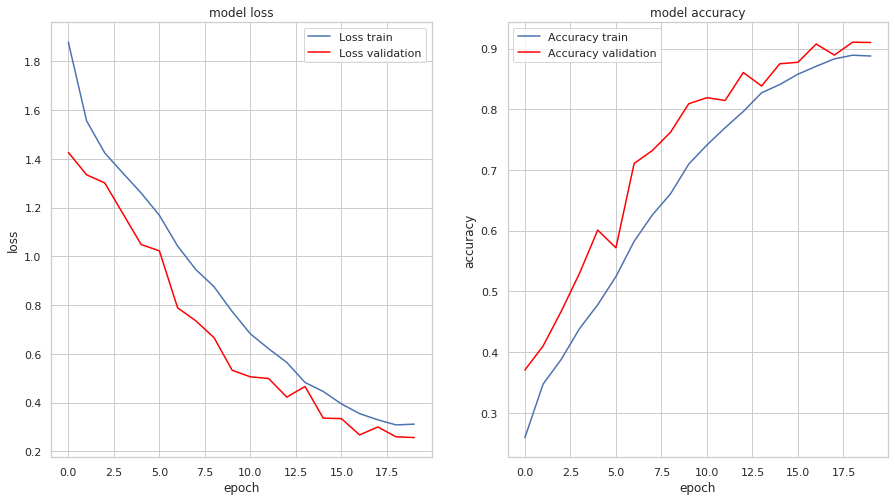

In [365]:
import mlflow

mlflow.set_experiment('awesome_advanced_approach')
tf.keras.backend.clear_session()
with mlflow.start_run(nested=True):
    # Log model hiperparameters first
    mlflow.log_param('description_features_layer_size', DESCRIPTION_FEATURES_LAYER_SIZE)
    mlflow.log_param('hidden_layer_size', HIDDEN_LAYER_SIZE)
    mlflow.log_param('embedded_columns', embedded_columns)
    mlflow.log_param('one_hot_columns', one_hot_columns)
    # mlflow.log_param('numerical_columns', numerical_columns)  # Not using these yet
    
    # Train
    epochs = 20
    history = model.fit(train_dataset, epochs=epochs, validation_data=dev_dataset,verbose=1)
    
    loss, accuracy = 0, 0
    loss, accuracy = model.evaluate(dev_dataset)
    print("*** Dev loss: {} - accuracy: {}".format(loss, accuracy))
    mlflow.log_metric('dev-loss', loss)
    mlflow.log_metric('dev-accuracy', accuracy)

    loss, accuracy = model.evaluate(train_dataset)
    print("*** Train loss: {} - accuracy: {}".format(loss, accuracy))
    mlflow.log_metric('train-loss', loss)
    mlflow.log_metric('train-accuracy', accuracy)
    
    
    #grafico
    plt.figure(figsize=(15,8))
    
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Loss train')
    plt.plot(history.history['val_loss'], color='red', label='Loss validation')
    plt.title('model loss')
    plt.ylabel('loss', size='12')
    plt.xlabel('epoch', size='12')
    plt.legend()
            
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Accuracy train')
    plt.plot(history.history['val_accuracy'], color='red', label='Accuracy validation')
    plt.title('model accuracy')
    plt.ylabel('accuracy', size='12')
    plt.xlabel('epoch',size='12')
    plt.legend()
    plt.show()


## Evaluando el modelo sobre los datos de evaluación para la competencia


In [366]:
dataset, test_dataset = load_dataset()
test_dataset = process_feature(test_dataset)
for num_column in numeric_columns:
  test_dataset[num_column] = StandardScaler().fit_transform(test_dataset[[num_column]].values)

Training samples 10582, test_samples 4411


In [367]:
test_dataset["TokenizedDescription"] = test_dataset["Description"]\
    .fillna(value="").apply(tokenize_description)

# Generate the basic TF dataset

tf_test_dataset = tf.data.Dataset.from_generator(
    lambda: dataset_generator(test_dataset, True),
    output_types=instance_types  # It should have the same instance types
)

for data in tf_test_dataset.take(2):  # The dataset only returns a data instance now (no target)
    pprint(data)
    print()

{'Breed1': <tf.Tensor: id=585619, shape=(1,), dtype=int32, numpy=array([265], dtype=int32)>,
 'Breed2': <tf.Tensor: id=585620, shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>,
 'State': <tf.Tensor: id=585621, shape=(1,), dtype=int32, numpy=array([3], dtype=int32)>,
 'description': <tf.Tensor: id=585622, shape=(13,), dtype=int32, numpy=
array([  89,  432, 1416, 1048,  367,    1, 7917, 1180,   63,  606,  752,
          5,    1], dtype=int32)>,
 'direct_features': <tf.Tensor: id=585623, shape=(34,), dtype=float32, numpy=
array([ 1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        1.        ,  0.        ,  1.        ,  0.        , -0.52713054,
       -0.28477862, -0.38856784, -0.

In [0]:
test_data = tf_test_dataset.padded_batch(
    BATCH_SIZE, 
    padded_shapes=padding_shapes[0], 
    padding_values=padding_values[0]
)

In [0]:
test_dataset["AdoptionSpeed"] = model.predict(test_data).argmax(axis=1)

test_dataset.to_csv("./submission.csv", index=False, columns=["PID", "AdoptionSpeed"])

# Analisis


## Modelo 1


Modelo
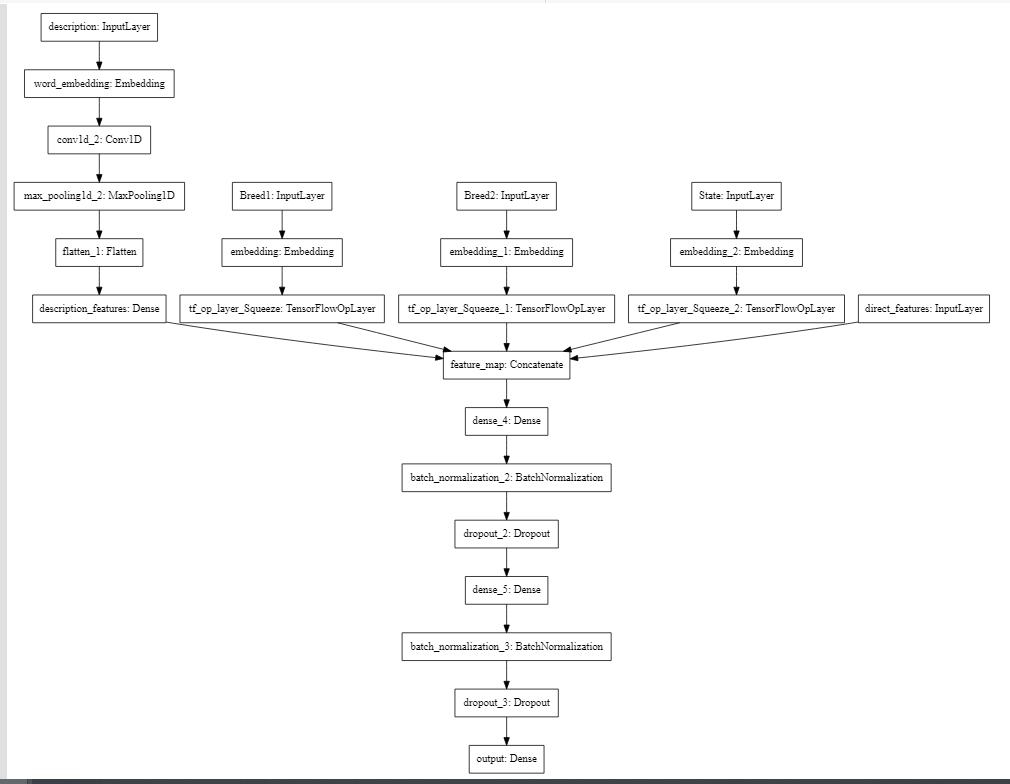


#### Trainning Log


```
Epoch 1/20
253/253 [==============================] - 28s 111ms/step - loss: 1.7528 - accuracy: 0.2983 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
253/253 [==============================] - 26s 101ms/step - loss: 1.4742 - accuracy: 0.3711 - val_loss: 1.2636 - val_accuracy: 0.4644
Epoch 3/20
253/253 [==============================] - 26s 102ms/step - loss: 1.3299 - accuracy: 0.4369 - val_loss: 1.0888 - val_accuracy: 0.5663
Epoch 4/20
253/253 [==============================] - 26s 103ms/step - loss: 1.1845 - accuracy: 0.4978 - val_loss: 0.9847 - val_accuracy: 0.6568
Epoch 5/20
253/253 [==============================] - 26s 103ms/step - loss: 1.0634 - accuracy: 0.5641 - val_loss: 0.8589 - val_accuracy: 0.6924
Epoch 6/20
253/253 [==============================] - 26s 103ms/step - loss: 0.9226 - accuracy: 0.6427 - val_loss: 0.6834 - val_accuracy: 0.7681
Epoch 7/20
253/253 [==============================] - 26s 104ms/step - loss: 0.7563 - accuracy: 0.7036 - val_loss: 0.5275 - val_accuracy: 0.8145
Epoch 8/20
253/253 [==============================] - 26s 103ms/step - loss: 0.6586 - accuracy: 0.7545 - val_loss: 0.5244 - val_accuracy: 0.8165
Epoch 9/20
253/253 [==============================] - 27s 106ms/step - loss: 0.5624 - accuracy: 0.7860 - val_loss: 0.5936 - val_accuracy: 0.7784
Epoch 10/20
253/253 [==============================] - 26s 105ms/step - loss: 0.4788 - accuracy: 0.8193 - val_loss: 0.3890 - val_accuracy: 0.8610
Epoch 11/20
253/253 [==============================] - 26s 104ms/step - loss: 0.4140 - accuracy: 0.8460 - val_loss: 0.2907 - val_accuracy: 0.8867
Epoch 12/20
253/253 [==============================] - 26s 105ms/step - loss: 0.3613 - accuracy: 0.8680 - val_loss: 0.2911 - val_accuracy: 0.8971
Epoch 13/20
253/253 [==============================] - 26s 104ms/step - loss: 0.3229 - accuracy: 0.8780 - val_loss: 0.3355 - val_accuracy: 0.8744
Epoch 14/20
253/253 [==============================] - 26s 104ms/step - loss: 0.3005 - accuracy: 0.8894 - val_loss: 0.2801 - val_accuracy: 0.9001
Epoch 15/20
253/253 [==============================] - 26s 104ms/step - loss: 0.2745 - accuracy: 0.8999 - val_loss: 0.2056 - val_accuracy: 0.9233
Epoch 16/20
253/253 [==============================] - 26s 105ms/step - loss: 0.2643 - accuracy: 0.9034 - val_loss: 0.1641 - val_accuracy: 0.9421
Epoch 17/20
253/253 [==============================] - 26s 104ms/step - loss: 0.2392 - accuracy: 0.9139 - val_loss: 0.1773 - val_accuracy: 0.9352
Epoch 18/20
253/253 [==============================] - 26s 104ms/step - loss: 0.2300 - accuracy: 0.9179 - val_loss: 0.1520 - val_accuracy: 0.9451
Epoch 19/20
253/253 [==============================] - 27s 105ms/step - loss: 0.2286 - accuracy: 0.9212 - val_loss: 0.2061 - val_accuracy: 0.9233
Epoch 20/20
253/253 [==============================] - 26s 104ms/step - loss: 0.1995 - accuracy: 0.9279 - val_loss: 0.1267 - val_accuracy: 0.9525
64/64 [==============================] - 12s 187ms/step - loss: 0.1507 - accuracy: 0.9535
*** Dev loss: 0.15065645665163174 - accuracy: 0.9535113573074341
253/253 [==============================] - 13s 51ms/step - loss: 0.1344 - accuracy: 0.9577
*** Train loss: 0.13439384585047665 - accuracy: 0.9576994180679321
```

#### Accuracy and Loss plot
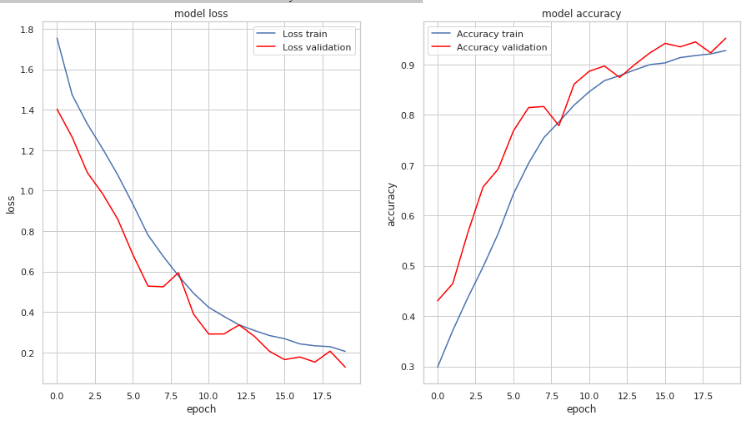
#### Kaggle (late) submission:

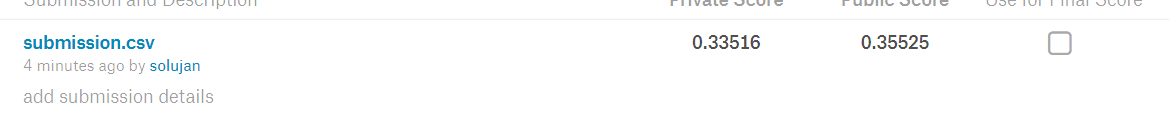

## Modelo 2


### Model
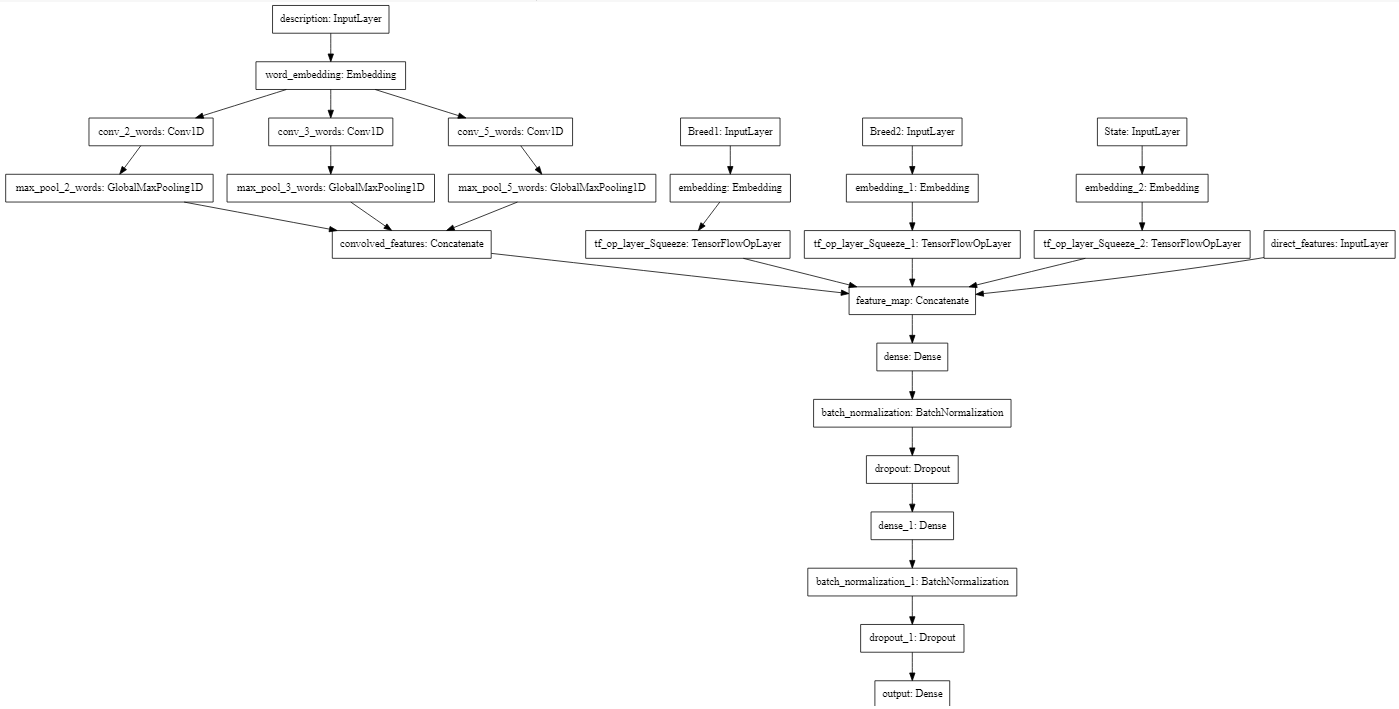

### Training Log

```
Epoch 1/10
253/253 [==============================] - 26s 102ms/step - loss: 0.2143 - accuracy: 0.9229 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
253/253 [==============================] - 26s 102ms/step - loss: 0.1868 - accuracy: 0.9342 - val_loss: 0.1147 - val_accuracy: 0.9580
Epoch 3/10
253/253 [==============================] - 25s 100ms/step - loss: 0.1707 - accuracy: 0.9382 - val_loss: 0.0945 - val_accuracy: 0.9594
Epoch 4/10
253/253 [==============================] - 25s 100ms/step - loss: 0.1987 - accuracy: 0.9296 - val_loss: 0.1282 - val_accuracy: 0.9570
Epoch 5/10
253/253 [==============================] - 25s 100ms/step - loss: 0.1949 - accuracy: 0.9300 - val_loss: 0.1926 - val_accuracy: 0.9293
Epoch 6/10
253/253 [==============================] - 25s 100ms/step - loss: 0.1809 - accuracy: 0.9369 - val_loss: 0.1909 - val_accuracy: 0.9550
Epoch 7/10
253/253 [==============================] - 25s 101ms/step - loss: 0.1721 - accuracy: 0.9388 - val_loss: 0.1629 - val_accuracy: 0.9476
Epoch 8/10
253/253 [==============================] - 25s 100ms/step - loss: 0.1785 - accuracy: 0.9394 - val_loss: 0.1143 - val_accuracy: 0.9594
Epoch 9/10
253/253 [==============================] - 25s 100ms/step - loss: 0.1644 - accuracy: 0.9437 - val_loss: 0.1079 - val_accuracy: 0.9669
Epoch 10/10
253/253 [==============================] - 26s 102ms/step - loss: 0.1869 - accuracy: 0.9326 - val_loss: 0.2139 - val_accuracy: 0.9332
64/64 [==============================] - 12s 185ms/step - loss: 0.2338 - accuracy: 0.9283
*** Dev loss: 0.2338384945251164 - accuracy: 0.9282888174057007
253/253 [==============================] - 13s 50ms/step - loss: 0.1991 - accuracy: 0.9343
*** Train loss: 0.19908139161147148 - accuracy: 0.9343228340148926
```
### Accuracy and loss graph

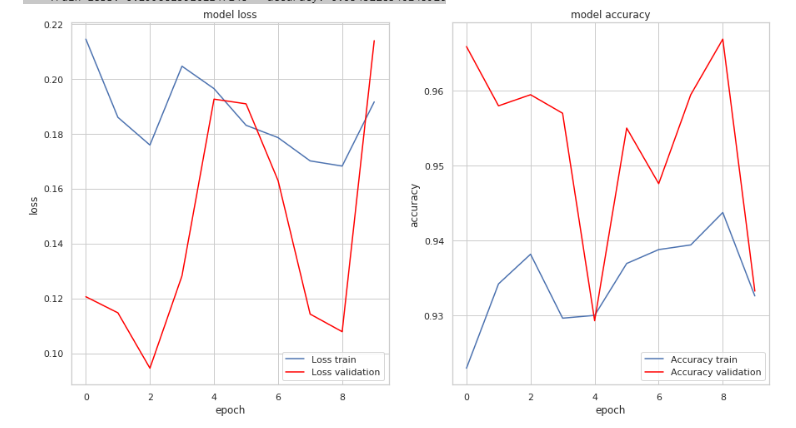

## Kaggle submission

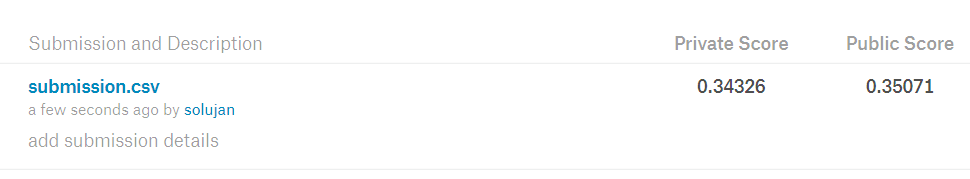

## Modelo 3

### Model
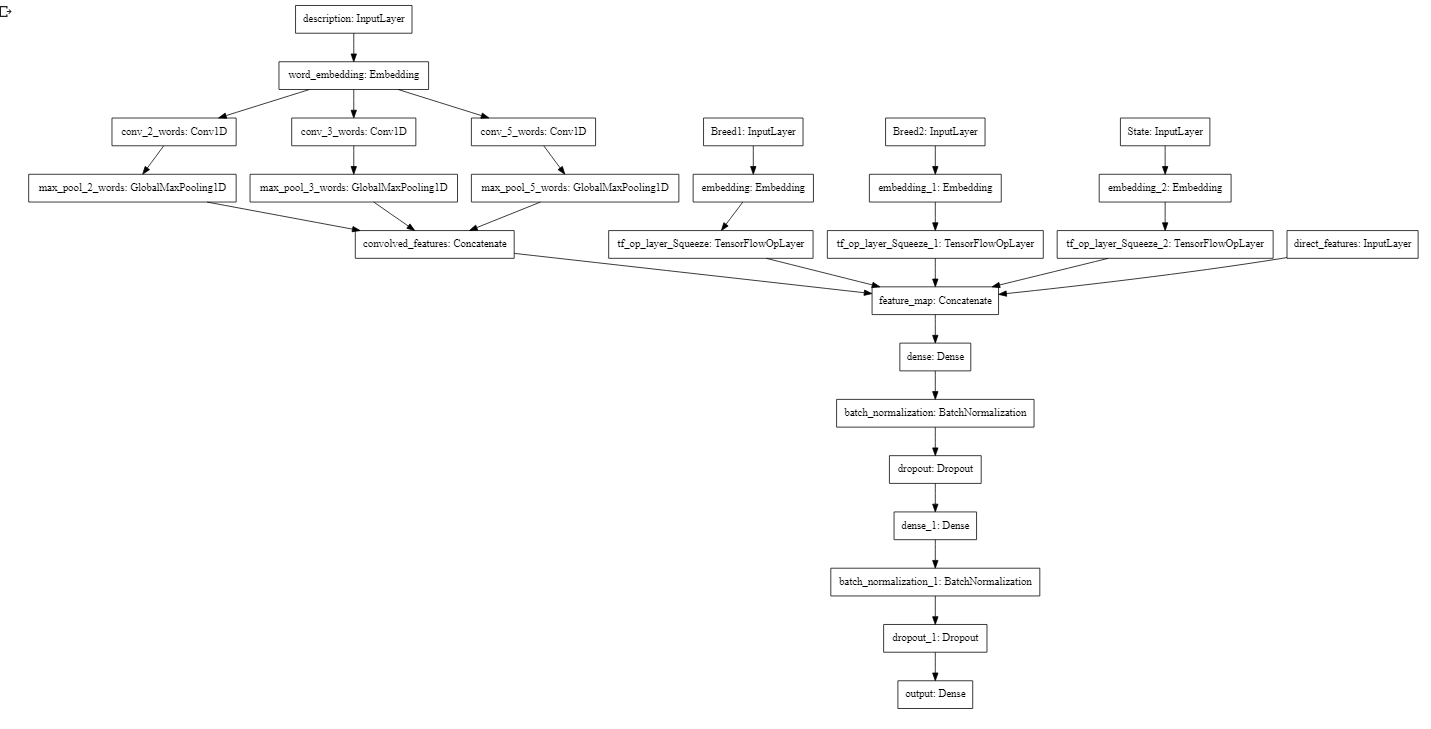
### Trainning Log


```
Epoch 1/20
127/127 [==============================] - 28s 220ms/step - loss: 1.8769 - accuracy: 0.2591 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
127/127 [==============================] - 26s 206ms/step - loss: 1.5540 - accuracy: 0.3472 - val_loss: 1.3345 - val_accuracy: 0.4100
Epoch 3/20
127/127 [==============================] - 26s 205ms/step - loss: 1.4255 - accuracy: 0.3881 - val_loss: 1.3009 - val_accuracy: 0.4674
Epoch 4/20
127/127 [==============================] - 26s 205ms/step - loss: 1.3357 - accuracy: 0.4386 - val_loss: 1.1747 - val_accuracy: 0.5297
Epoch 5/20
127/127 [==============================] - 26s 207ms/step - loss: 1.2547 - accuracy: 0.4779 - val_loss: 1.0485 - val_accuracy: 0.6009
Epoch 6/20
127/127 [==============================] - 26s 205ms/step - loss: 1.1660 - accuracy: 0.5243 - val_loss: 1.0225 - val_accuracy: 0.5717
Epoch 7/20
127/127 [==============================] - 26s 204ms/step - loss: 1.0411 - accuracy: 0.5824 - val_loss: 0.7892 - val_accuracy: 0.7107
Epoch 8/20
127/127 [==============================] - 26s 204ms/step - loss: 0.9277 - accuracy: 0.6259 - val_loss: 0.7357 - val_accuracy: 0.7319
Epoch 9/20
127/127 [==============================] - 26s 205ms/step - loss: 0.8607 - accuracy: 0.6607 - val_loss: 0.6668 - val_accuracy: 0.7621
Epoch 10/20
127/127 [==============================] - 26s 206ms/step - loss: 0.7654 - accuracy: 0.7096 - val_loss: 0.5328 - val_accuracy: 0.8091
Epoch 11/20
127/127 [==============================] - 26s 206ms/step - loss: 0.6757 - accuracy: 0.7411 - val_loss: 0.5060 - val_accuracy: 0.8190
Epoch 12/20
127/127 [==============================] - 26s 206ms/step - loss: 0.6171 - accuracy: 0.7696 - val_loss: 0.4994 - val_accuracy: 0.8145
Epoch 13/20
127/127 [==============================] - 26s 205ms/step - loss: 0.5563 - accuracy: 0.7964 - val_loss: 0.4229 - val_accuracy: 0.8605
Epoch 14/20
127/127 [==============================] - 26s 204ms/step - loss: 0.4785 - accuracy: 0.8271 - val_loss: 0.4665 - val_accuracy: 0.8383
Epoch 15/20
127/127 [==============================] - 26s 204ms/step - loss: 0.4378 - accuracy: 0.8407 - val_loss: 0.3368 - val_accuracy: 0.8749
Epoch 16/20
127/127 [==============================] - 26s 202ms/step - loss: 0.3877 - accuracy: 0.8578 - val_loss: 0.3347 - val_accuracy: 0.8773
Epoch 17/20
127/127 [==============================] - 26s 202ms/step - loss: 0.3486 - accuracy: 0.8707 - val_loss: 0.2679 - val_accuracy: 0.9075
Epoch 18/20
127/127 [==============================] - 26s 202ms/step - loss: 0.3242 - accuracy: 0.8830 - val_loss: 0.3005 - val_accuracy: 0.8892
Epoch 19/20
127/127 [==============================] - 26s 201ms/step - loss: 0.2950 - accuracy: 0.8891 - val_loss: 0.2601 - val_accuracy: 0.9105
Epoch 20/20
127/127 [==============================] - 26s 201ms/step - loss: 0.3058 - accuracy: 0.8877 - val_loss: 0.2572 - val_accuracy: 0.9100
32/32 [==============================] - 11s 358ms/step - loss: 0.2370 - accuracy: 0.9100
*** Dev loss: 0.23702059825882316 - accuracy: 0.909990131855011
127/127 [==============================] - 12s 97ms/step - loss: 0.2656 - accuracy: 0.9028
*** Train loss: 0.26558506987460956 - accuracy: 0.9027829170227051
```


### Accuracy and Loss graph
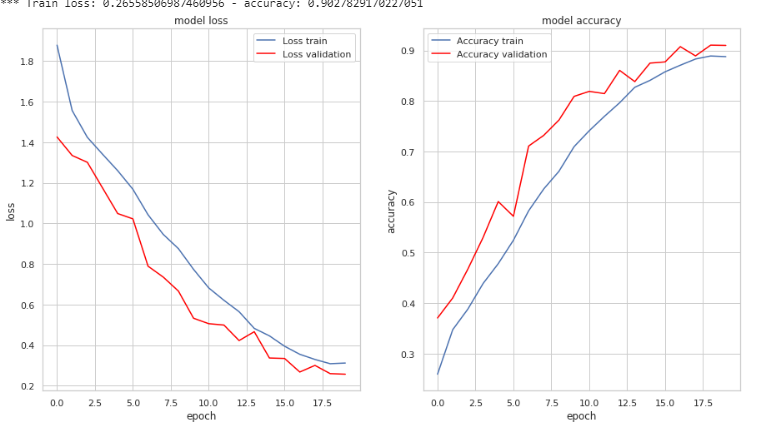
### Kaggle submission


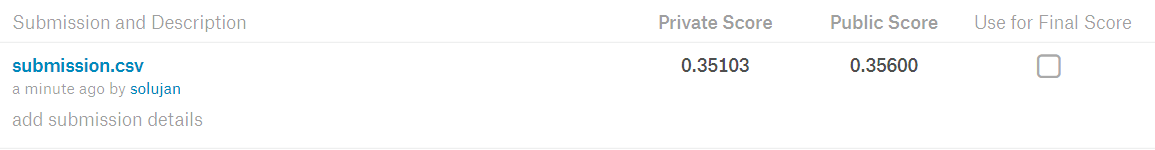